In [2]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset

class FactVerificationDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        item = self.data[index]
        encoded_input = self.tokenizer.encode_plus(
            item['Claim'],
            item['Most Relevant Sentence'],
            padding='max_length',
            truncation=True,
            max_length=512,
            return_tensors='pt'
        )
        label = item['label']
        return {
            'input_ids': encoded_input['input_ids'].squeeze(),
            'attention_mask': encoded_input['attention_mask'].squeeze(),
            'label': torch.tensor(label)
        }

In [2]:
pip install transformers

In [1]:
# Step 2: Load the pre-trained model
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

NameError: name 'RobertaForSequenceClassification' is not defined

In [ ]:
import json

# Step 1: Open the JSON file
with open('/content/results_5000 (1).json', 'r', encoding='utf-8') as file:
    # Step 2: Parse the JSON data
    data = json.load(file)

# Step 3: Access the data
print(data)

In [5]:
training_data = data[:4500]
testing_data = data[4500:5001]


In [6]:
dataset = FactVerificationDataset(training_data)

In [7]:
# Step 4: Model architecture and fine-tuning
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Step 5: Train the model
optimizer = AdamW(model.parameters(), lr=2e-5)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)# Step 4: Model architecture and fine-tuning
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Step 5: Train the model
optimizer = AdamW(model.parameters(), lr=2e-5)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [8]:
num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    average_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs} - Average Loss: {average_loss}")


Epoch 1/2 - Average Loss: 0.3723942962547777
Epoch 2/2 - Average Loss: 0.12880929779254746


In [9]:
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [10]:
evaluation_dataset = FactVerificationDataset(testing_data)  # Replace eval_data with your evaluation dataset
evaluation_dataloader = DataLoader(evaluation_dataset, batch_size=16, shuffle=False)

In [11]:

correct_predictions = 0
total_predictions = 0

for batch in evaluation_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        predicted_labels = torch.argmax(outputs.logits, dim=1)

    correct_predictions += (predicted_labels == labels).sum().item()
    total_predictions += len(labels)

accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy}")

Accuracy: 0.954


In [12]:
correct_predictions = 0
total_predictions = 0
predicted_labels_list = []  # List to store predicted labels
original_labels_list = []   # List to store original labels

for batch in evaluation_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        predicted_labels = torch.argmax(outputs.logits, dim=1)

    correct_predictions += (predicted_labels == labels).sum().item()
    total_predictions += len(labels)

    # Append predicted and original labels to their respective lists
    predicted_labels_list.extend(predicted_labels.cpu().numpy())
    original_labels_list.extend(labels.cpu().numpy())

accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy}")

# Now you can work with predicted_labels_list and original_labels_list outside the loop


Accuracy: 0.954


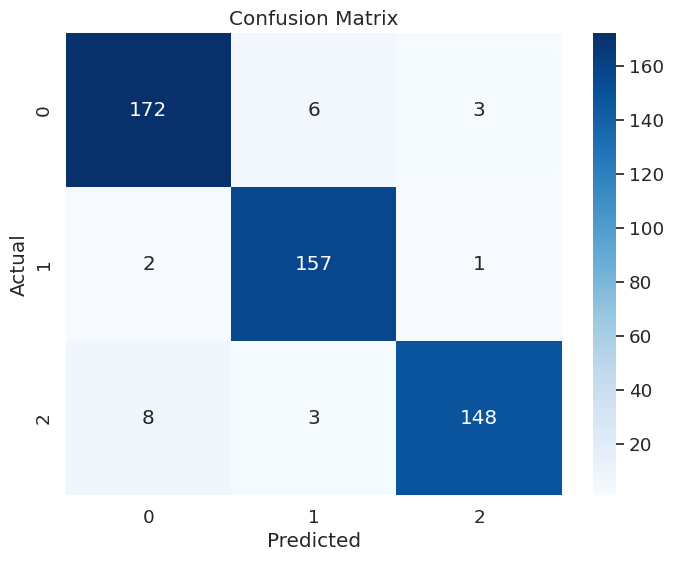

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming correct_predictions and predicted_labels are your data
correct_predictions = [0, 1, 2, 0, 1, 2, 0, 1, 2]
predicted_labels = [0, 1, 2, 1, 0, 1, 2, 0, 2]

# Get unique labels from the data
labels = [0,1,2]

# Create the confusion matrix
conf_matrix = confusion_matrix(original_labels_list, predicted_labels_list, labels=labels)

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [14]:
true_positives = 0
false_positives = 0
false_negatives = 0

for batch in evaluation_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

        # Check if 'logits' key exists in outputs
        if 'logits' in outputs:
            logits = outputs.logits
        else:
            # If 'logits' key is not present, try to access from 'last_hidden_state'
            logits = outputs.last_hidden_state[:, 0, :]  # Assuming XLM-RoBERTa, take the [CLS] token representation

        predicted_labels = torch.argmax(logits, dim=1)

    true_positives += ((predicted_labels == 1) & (labels == 1)).sum().item()
    false_positives += ((predicted_labels == 1) & (labels == 0)).sum().item()
    false_negatives += ((predicted_labels == 0) & (labels == 1)).sum().item()

precision = true_positives / (true_positives + false_positives + 1e-10)
recall = true_positives / (true_positives + false_negatives + 1e-10)
f1_score = 2 * (precision * recall) / (precision + recall + 1e-10)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")


Precision: 0.9631901840484889
Recall: 0.9874213836471778
F1 Score: 0.9751552794525077


In [15]:
from sklearn.metrics import classification_report

# Assuming original_labels_list and predicted_labels_list are your data


# Get unique labels from the data
labels = sorted(set(original_labels_list + predicted_labels_list))

# Compute the classification report
class_report = classification_report(original_labels_list, predicted_labels_list, labels=labels)

# Print the classification report
print("Classification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       181
           1       0.95      0.98      0.96       160
           2       0.97      0.93      0.95       159

    accuracy                           0.95       500
   macro avg       0.95      0.95      0.95       500
weighted avg       0.95      0.95      0.95       500



In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score



# Get unique labels from the data
labels = sorted(set(original_labels_list + predicted_labels_list))

# Compute precision, recall, and F1 score for each class
precision_per_class = precision_score(original_labels_list, predicted_labels_list, labels=labels, average=None)
recall_per_class = recall_score(original_labels_list, predicted_labels_list, labels=labels, average=None)
f1_per_class = f1_score(original_labels_list, predicted_labels_list, labels=labels, average=None)

# Compute micro and macro averages
micro_precision = precision_score(original_labels_list, predicted_labels_list, average='micro')
micro_recall = recall_score(original_labels_list, predicted_labels_list, average='micro')
micro_f1 = f1_score(original_labels_list, predicted_labels_list, average='micro')

macro_precision = precision_score(original_labels_list, predicted_labels_list, average='macro')
macro_recall = recall_score(original_labels_list, predicted_labels_list, average='macro')
macro_f1 = f1_score(original_labels_list, predicted_labels_list, average='macro')

# Print or use the results as needed


In [18]:
print(micro_f1)

0.954


In [17]:
print(macro_f1)

0.9542056916663059
